## Activity 07
### Tyler Barna

In [133]:
## import modules (running on python 3.9.12)

import matplotlib.pyplot as plt

cm = plt.cm.get_cmap('RdYlBu')
import numpy as np
import pandas as pd
#import pymc3 as pm
import random
import scipy
import seaborn as sns

from astropy.io import fits
from astropy.io import ascii

import scipy.stats as stats
from scipy.stats import betabinom
from scipy.stats import binom
from scipy.stats import beta
from scipy.stats import gamma
from scipy.stats import invgamma
from scipy.stats import nbinom
from scipy.stats import norm
from scipy.stats import poisson
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import multivariate_normal as mvn


from tabulate import tabulate as tab


## set seed for reproducibility
random.seed(5731) 

## import data
ceph_df = pd.read_csv('./cepheid_data.csv')
df = pd.read_csv('./fundamental_plane_kpc.csv')

#display(ceph_df.describe()) ## not used in this notebook
display(df.describe())

,ID,A_R,LogRe,mue,logSigma,eLogSigma,velocity,Type
count,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,49.640401,0.162911,0.526437,19.486920,2.254963,0.026850,7971.922636,-3.717765
std,28.808444,0.124168,0.305982,0.768645,0.150534,0.009911,3027.429422,1.392437
min,0.000000,0.015000,-0.385867,17.020000,1.720000,0.008000,2089.000000,-5.000000
25%,25.000000,0.060250,0.337553,18.982500,2.155250,0.020000,5413.500000,-5.000000
50%,50.000000,0.144000,0.510618,19.450000,2.273000,0.026000,7869.000000,-4.000000
75%,74.750000,0.209000,0.701511,19.940000,2.365000,0.033500,9951.000000,-2.000000
max,99.000000,0.605000,1.830392,22.550000,2.600000,0.056000,15799.000000,-2.000000


Following the guideline notebook and taking

\begin{equation}
x = 0.205 \mu_e + \text{log}\left(\sigma\right)
\end{equation}

where $\mu_e$ is the mean R-band surface brightness within the effective radius and $\text{log}\left(\sigma\right)$ iss the log of the central velocity dispersion; we can plot the data and fit a line to it. the y is taken to be

\begin{equation}
y = \text{log}\left(R_e\right)
\end{equation}

where $\text{log}\left(R_e\right)$ is the log of the effective radius in kpc. I also assign a colormap that corresponds to the type of galaxy, where Type $\ge$ -4 corresponds to Ellipticals and $-3\le$ Type $\le-1$ corresponds to S0

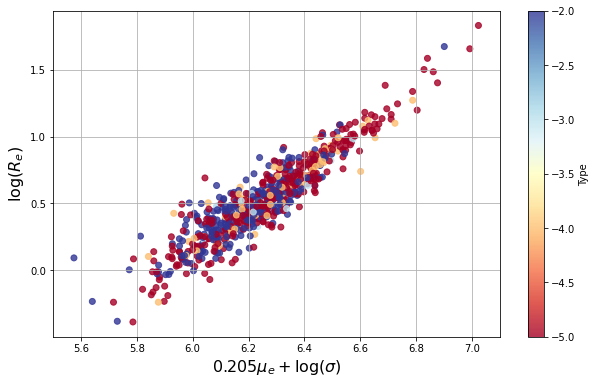

In [127]:
## setup matrices
x, y = (0.205*df['mue']+df['logSigma'], 
        df['LogRe']) 
x2 = df['logSigma']


## plotting
fig, ax = plt.subplots(figsize=(10, 6),facecolor='white')
ax.set_xlim(5.5,7.1)
ax.grid()
ax.set_xlabel(r'$0.205 \mu_e + \log(\sigma)$',fontsize=16)
ax.set_ylabel(r'$\log(R_e)$',fontsize=16)

cm = plt.cm.get_cmap('RdYlBu') ## color map
scat = ax.scatter(x, y, c=df['Type'], 
                  alpha=0.8,cmap=cm, 
                  label='Data')
cbat = plt.colorbar(scat)
cbat.set_label(r'Type')

To perform the liniar regression, we take

\begin{equation}
Y = \beta_i X_i + \epsilon
\end{equation}

where $\epsilon \sim N(0,\lambda^{-1})$

shape of X:  (698, 2)
shape of y:  (698,) 

mle estimator (slope, intercept):  [[-8.15618211  1.38926761]]


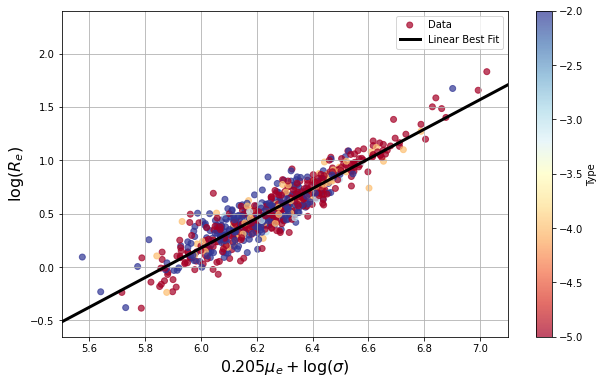

In [128]:
## mle estimator
X = np.matrix([np.ones(x.shape[0]), x]).T
# X[:,1] = x

print('shape of X: ',X.shape)
print('shape of y: ',y.shape,'\n')

p_mat = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

print('mle estimator (slope, intercept): ',p_mat)

## define xx and yy variable for plotting
xx = np.linspace(5.5, 7.5, 100)
yy = np.array(p_mat[0,0] + p_mat[0,1]*xx)


## plotting
fig, ax = plt.subplots(figsize=(10, 6),facecolor='white')
ax.set_xlim(5.5,7.1)
ax.grid()
ax.set_xlabel(r'$0.205 \mu_e + \log(\sigma)$',fontsize=16)
ax.set_ylabel(r'$\log(R_e)$',fontsize=16)

cm = plt.cm.get_cmap('RdYlBu') ## color map
scat = ax.scatter(x, y, c=df['Type'], 
                  alpha=0.7,cmap=cm, 
                  label='Data')
cbat = plt.colorbar(scat)
cbat.set_label(r'Type')

logSigma = np.linspace(5.5,7.5,x.shape[0])
ax.plot(xx, yy, 
        lw=3,color='black',
        label='Linear Best Fit')

ax.legend();

Now, we should try to do the Bayesian approach to regression

As outlined in the example notebook, we need to find a joint posterior using a reference prior $\pi(\beta, \lambda)\propto \lambda^{-1}$

$$q(\beta,\lambda) = q(\beta|\lambda, Y, X)q(\lambda|Y, X)$$

where $\beta|\lambda,Y,X \sim N_p \left(\hat{\beta},\left(\lambda X^TX \right)^{-1}\right)$ and $\lambda |Y,X\sim Gamma\left( \frac{1}{2}  (n−p), \frac{1}{2} \left(Y −X\hat{\beta}\right)^T  \left(Y −X\hat{\beta}\right)\right)$

In [129]:
## compute res and sse
res = np.array([y - p_mat[0,0] - p_mat[0,1] * x])
sse = np.sum(res**2)

## gamma params
a_gam = (len(y)-2)/2
b_gam = sse/2

n_real = 10000
lam_vec = np.zeros(n_real)
betarray = np.zeros((n_real,2))

for j in range(n_real):
    lam_vec[j] = gamma.rvs(a_gam, scale=1/b_gam,size=1) 
    s_beta = np.linalg.inv(lam_vec[j]*X.T.dot(X))
    betarray[j,:]=mvn.rvs(mean=np.array([p_mat[0,0],p_mat[0,1]]), cov=s_beta, size=1)

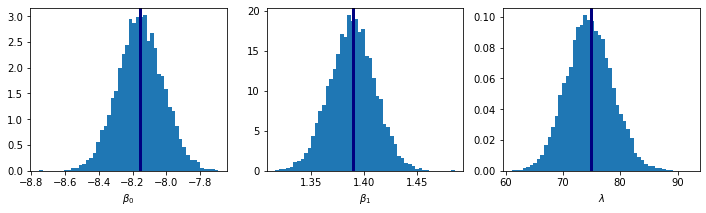

        Beta_0    Beta_1    Lambda
----  --------  --------  --------
Mean  -8.15353   1.38884   74.6473
5%    -8.37532   1.35366   68.1634
95%   -7.93359   1.42431   81.307


In [130]:
fig, [ax1,ax2,ax3] = plt.subplots(1,3,figsize=(12,3))

idx = 0
for ax in (ax1,ax2):
    ax.set_xlabel(r'$\beta_%s$'%str(idx))
    ax.axvline(p_mat[0,idx],
               lw=3,color='navy',
               label='MLE',)
    ax.hist(betarray[:,idx],density=True,bins=50)
    idx+=1
ax3.set_xlabel(r'$\lambda$')
ax3.axvline(len(y)/np.sum(res**2), 
            lw=3,color='navy',
            label='MLE')
ax3.hist(lam_vec,density=True,bins=50);
plt.show();


dat = [
       ['Mean', np.mean(betarray[:,0]),np.mean(betarray[:,1]),np.mean(lam_vec)],
       ['5%', np.percentile(betarray[:,0],5),np.percentile(betarray[:,1],5),np.percentile(lam_vec,5)],
       ['95%', np.percentile(betarray[:,0],95),np.percentile(betarray[:,1],95),np.percentile(lam_vec,95)]
       ]
print(tab(dat,headers=['','Beta_0','Beta_1','Lambda']))

Now, to plot the theoretical distributions

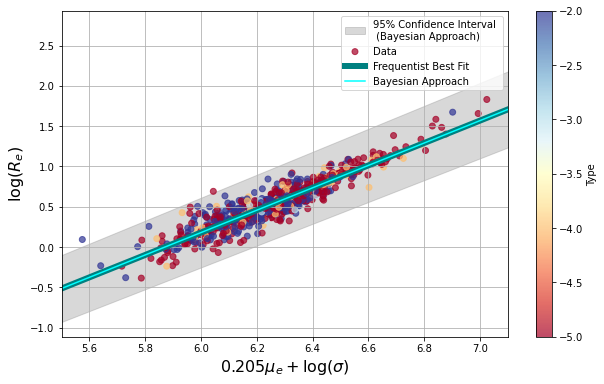

In [131]:
## plotting
fig, ax = plt.subplots(figsize=(10, 6),facecolor='white')
ax.set_xlim(5.5,7.1)
ax.grid()
ax.set_xlabel(r'$0.205 \mu_e + \log(\sigma)$',fontsize=16)
ax.set_ylabel(r'$\log(R_e)$',fontsize=16)

y05 = np.percentile(betarray[:,0],5) + np.percentile(betarray[:,1],5)*xx
y95 = np.percentile(betarray[:,0],95) + np.percentile(betarray[:,1],95)*xx
ymean = np.mean(betarray[:,0]) + np.mean(betarray[:,1])*xx

ax.fill_between(xx, y05, y95,
                color='grey', alpha=0.3,
                label='95% Confidence Interval \n (Bayesian Approach)')

cm = plt.cm.get_cmap('RdYlBu') ## color map
scat = ax.scatter(x, y, c=df['Type'], 
                  alpha=0.7,cmap=cm, 
                  label='Data')
cbat = plt.colorbar(scat)
cbat.set_label(r'Type')

logSigma = np.linspace(5.5,7.5,x.shape[0])
ax.plot(xx, yy, 
        lw=6,color='teal', alpha=1,
        label='Frequentist Best Fit')
ax.plot(xx, ymean,
        color='aqua',alpha=1,
        label='Bayesian Approach')

ax.legend();